## Multi Layer Perceptron Notebook

### Description:

This notebook aims to implement a **Multi Layer Perceptron Neural Network** for Forecasting Time Series.

As explained in the **SeriesAnalysis** notebook, this notebook may use the results already obtained in **Series Analysis**, so that the focus can be only on the Model itself. The results that will be used are the stationary series obtained from the original series, in order to verify if the **MLP Networks** are capable of forecasting both stationary and non stationary series.

### MLP brief introduction

# COMPLETE

In [3]:
#Packages needed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import neural_network
import sklearn.model_selection # hyperparameter search
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
# COMPLETE WITH PACKEGES FOR MLP

### Some useful functions -> COMPLETE WITH MORE IF NEEDED AND DELETE ONES NOT NEEDED

In [4]:
#Read and filter data from csv files, as well as handle missing values
def read_filter(path,index,value):
    df = pd.read_csv(path)
    series = df.loc[:,[index,value]]
    series.set_index(index,inplace=True)
    series.index=pd.to_datetime(series.index)
    series = series.asfreq('d')
    series = series.interpolate()
    return series

# #Ploting a single time series
# def plot_series(serie,title,xlabel,ylabel):
#     fig = plt.figure()
#     plt.plot(serie)
#     fig.suptitle(title, fontsize=20)
#     plt.xlabel(xlabel, fontsize=18)
#     plt.ylabel(ylabel, fontsize=18)
#     plt.show()

#plot two time series
def plot_2_series(real,model,title,xlabel="Time",ylabel="Values"):
    fig = plt.figure()
    plt.plot(real)
    plt.plot(model)
    fig.suptitle(title, fontsize=20)
    # plt.xlabel(xlabel, fontsize=18)
    # plt.ylabel(ylabel, fontsize=18)
    plt.legend(['Original Series','Predicted'])
    plt.show()
    
    
# differentiate the series
def diff(series,t):
    for i in range(t):
        series = series - series.shift(1)
        series = series.dropna()
    
    return series


#normalize time series values into range [0,1]
def normalize(serie):
    values = serie.values[:,0]

    _min = np.min(values)
    _max = np.max(values)
    
    norm_values = (values - _min)/(_max - _min)
    
    newSerie = pd.Series(norm_values)

    return newSerie

#spli_serie -> creates a Dataframe test and one for training
def split_serie(serie,lags,split):
    
    data_values = serie.values

    train_values = data_values[:-split].reshape(-1,1)
    test_values = data_values[-split:].reshape(-1,1)

    train_data = np.zeros((train_values.shape[0] - (lags + 1), lags + 2))
    test_data = np.zeros((test_values.shape[0], lags + 2))
    
    
    all_data = np.vstack((train_values,test_values))

    new_data = np.zeros((train_values.shape[0] - (lags + 1) + test_values.shape[0],lags + 2))
    
    
    for i in range(lags + 2):
        new_data[:,i] = all_data[i:new_data.shape[0]+i,0]

    train_data = new_data[:-test_values.shape[0],:]
    test_data = new_data[-test_values.shape[0]:,:]

    data_columns = [f'y(t{i})' if i < 0 else 'y(t)' if i == 0 else f'y(t+{i})' for i in range(-lags,2)] 
    new_train_df = pd.DataFrame(train_data, columns=data_columns,dtype=np.float64)
    new_test_df = pd.DataFrame(test_data, columns=data_columns,dtype=np.float64)

    return new_train_df,new_test_df



    
#Compute some error metrics
def errors(actual, predicted):
    mape = np.mean(np.abs(predicted - actual)/np.abs(actual))  # MAPE
    me = np.mean(predicted - actual)             # ME
    mae = np.mean(np.abs(predicted - actual))    # MAE
    mpe = np.mean((predicted - actual)/actual)   # MPE
    rmse = np.mean((predicted - actual)**2)**.5  # RMSE
    
    errors = [['MAPE',mape],['ME',me],['MAE',mae],['MPE',mpe],['RMSE',rmse]]
    
    errors = pd.DataFrame(errors,columns=['Error','Value'])
    return errors

#create_model -> returns a MLP model with the hyperparameters that were passed as input
def create_model(hidden_neurons = [4], hidden_activation = ['relu'], output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    model = Sequential()
    model.add(Dense(hidden_neurons[0], input_dim=n_input, activation='tanh'))
    for i in range(1,len(hidden_neurons)):
        model.add(Dense(hidden_neurons[i], input_dim=hidden_neurons[i-1], activation='tanh'))
        

    model.add(Dense(n_output, activation=output_activation))
    # Compile model
    opt = Adam(learning_rate=lr)
    model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_absolute_error','mean_squared_error','accuracy'])
    return model




### Importing the series and differenciating in order to get stationary behavior

In [5]:
#Importing the dataset and making some changes
USD_CAD_serie = read_filter('../data/CAD=X.csv','Date','Adj Close')
USD_BRL_serie = read_filter('../data/BRL=X.csv','Date','Adj Close')
AmericanAirlines_serie = read_filter('../data/AAL2010_2019.csv','Date','Adj Close')

#differentiating the series
USD_CAD_serie_diff1 = diff(USD_CAD_serie,1)
USD_BRL_serie_diff1 = diff(USD_BRL_serie,1)
AmericanAirlines_serie_diff1 = diff(AmericanAirlines_serie,1)

## Training and Test Sets

# COMPLETE !!!!!!!!!!!

First of all, we should normaize the series values so that they are all between [0,1]

In [6]:
AmericanAirlines_serie_diff1 = normalize(AmericanAirlines_serie_diff1)
USD_CAD_serie_diff1 = normalize(USD_CAD_serie_diff1)
USD_BRL_serie_diff1 = normalize(USD_BRL_serie_diff1)

In [7]:
largest_horizon = 12 #12 weeks, 3 months
split = 12 #number of entries for test
lags = 12 #number of past values that will be used to train the model

train_American_diff1, test_American_diff1 = split_serie(AmericanAirlines_serie_diff1,lags,split)
train_USD_CAD_diff1, test_USD_CAD_diff1 = split_serie(USD_CAD_serie_diff1,lags,split)
train_USD_BRL_diff1, test_USD_BRL_diff1 = split_serie(USD_BRL_serie_diff1,lags,split)

#Let's take a look into the test series
print(test_American_diff1.head())

#Let's just take a look into the dataframe.
train_American_diff1.head()

    y(t-12)   y(t-11)   y(t-10)    y(t-9)    y(t-8)    y(t-7)    y(t-6)  \
0  0.549209  0.549209  0.549209  0.549209  0.576552  0.576552  0.576552   
1  0.549209  0.549209  0.549209  0.576552  0.576552  0.576552  0.576552   
2  0.549209  0.549209  0.576552  0.576552  0.576552  0.576552  0.576552   
3  0.549209  0.576552  0.576552  0.576552  0.576552  0.576552  0.576552   
4  0.576552  0.576552  0.576552  0.576552  0.576552  0.576552  0.576552   

     y(t-5)    y(t-4)    y(t-3)    y(t-2)    y(t-1)      y(t)    y(t+1)  
0  0.576552  0.576552  0.576552  0.576552  0.599207  0.599207  0.599207  
1  0.576552  0.576552  0.576552  0.599207  0.599207  0.599207  0.599207  
2  0.576552  0.576552  0.599207  0.599207  0.599207  0.599207  0.599207  
3  0.576552  0.599207  0.599207  0.599207  0.599207  0.599207  0.599207  
4  0.599207  0.599207  0.599207  0.599207  0.599207  0.599207  0.599207  


,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.537584,0.537584,0.537584,0.537584,0.537584,0.537584,0.537584,0.502102,0.502102,0.502102,0.502102,0.502102,0.502102,0.502102
1,0.537584,0.537584,0.537584,0.537584,0.537584,0.537584,0.502102,0.502102,0.502102,0.502102,0.502102,0.502102,0.502102,0.488057
2,0.537584,0.537584,0.537584,0.537584,0.537584,0.502102,0.502102,0.502102,0.502102,0.502102,0.502102,0.502102,0.488057,0.488057
3,0.537584,0.537584,0.537584,0.537584,0.502102,0.502102,0.502102,0.502102,0.502102,0.502102,0.502102,0.488057,0.488057,0.488057
4,0.537584,0.537584,0.537584,0.502102,0.502102,0.502102,0.502102,0.502102,0.502102,0.502102,0.488057,0.488057,0.488057,0.488057


We need to understand that dataframe.

Each row will be the input of the MLP and the last column *Y(t+1)* is the target, which will be used to learn the right parameters during training.

Note that, in each row, we have a fraction of the series dislocated each time by 1 unit.

In [8]:
american_X_train = train_American_diff1.values[:,:-1]
american_y_train = train_American_diff1.values[:,-1]

american_X_test = test_American_diff1.values[:,:-1]
american_y_test = test_American_diff1.values[:,-1]

USD_CAD_X_train = train_USD_CAD_diff1.values[:,:-1]
USD_CAD_y_train = train_USD_CAD_diff1.values[:,-1]

USD_CAD_X_test = test_USD_CAD_diff1.values[:,:-1]
USD_CAD_y_test = test_USD_CAD_diff1.values[:,-1]

USD_BRL_X_train = train_USD_BRL_diff1.values[:,:-1]
USD_BRL_y_train = train_USD_BRL_diff1.values[:,-1]

USD_BRL_X_test = test_USD_BRL_diff1.values[:,:-1]
USD_BRL_y_test = test_USD_BRL_diff1.values[:,-1]

## Hyperparameter search

In [12]:
#Hyperparameters
hidden_layer_sizes = [20,50,100,(20,50),(20,50,100)]
solver = ["adam","sgd","lbfgs"]
random_state = [0]
activation = ["identity","tanh","relu"]
learning_rate = ['constant','adaptive']
learning_rate_init = [0.001,0.01,0.05,0.1]

In [13]:
import warnings
warnings.filterwarnings(action='ignore')

clf = sklearn.neural_network.MLPRegressor()
param_grid = {'random_state':random_state,
            'solver':solver,
            'hidden_layer_sizes':hidden_layer_sizes,
            'activation':activation,
            'learning_rate':learning_rate,
            'learning_rate_init':learning_rate_init
            }


clf_grid_American = sklearn.model_selection.GridSearchCV(clf, param_grid).fit(american_X_train,american_y_train)
print("Done 1")
clf_grid_USD_CAD = sklearn.model_selection.GridSearchCV(clf, param_grid).fit(USD_CAD_X_train,USD_CAD_y_train)
print("Done 2")
clf_grid_USD_BRL = sklearn.model_selection.GridSearchCV(clf, param_grid).fit(USD_BRL_X_train,USD_BRL_y_train)
print("Done 3")

Done 1
Done 2
Done 3


In [14]:
print('Best Hyperparameters American' ,clf_grid_American.best_params_)
print('Training Accuracy American',clf_grid_American.score(american_X_train,american_y_train))

print('\nBest Hyperparameters USD/CAD' ,clf_grid_USD_CAD.best_params_)
print('Training Accuracy USD/CAD',clf_grid_USD_CAD.score(USD_CAD_X_train,USD_CAD_y_train))

print('\nBest Hyperparameters USD/CAD' ,clf_grid_USD_BRL.best_params_)
print('Training Accuracy USD/BRL',clf_grid_USD_BRL.score(USD_BRL_X_train,USD_BRL_y_train))

Best Hyperparameters American {'activation': 'identity', 'hidden_layer_sizes': 20, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'random_state': 0, 'solver': 'lbfgs'}
Training Accuracy American 0.7960719178159243

Best Hyperparameters USD/CAD {'activation': 'relu', 'hidden_layer_sizes': (20, 50), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'random_state': 0, 'solver': 'lbfgs'}
Training Accuracy USD/CAD 0.8004337863388389

Best Hyperparameters USD/CAD {'activation': 'identity', 'hidden_layer_sizes': (20, 50), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'random_state': 0, 'solver': 'lbfgs'}
Training Accuracy USD/BRL 0.801278387705314


## Creating the models with the best hyperparameters (sklnear only)

In [15]:
clf_American = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=20,
                                activation='identity',
                                solver='lbfgs',
                                learning_rate="constant",
                                learning_rate_init=0.001,
                                random_state=0).fit(american_X_train,american_y_train)


clf_USD_CAD = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(20,50),
                                activation='relu',
                                solver='lbfgs',
                                learning_rate="constant",
                                learning_rate_init=0.001,
                                random_state=0).fit(USD_CAD_X_train,USD_CAD_y_train)

clf_USD_BRL = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(20,50),
                                activation='identity',
                                solver='lbfgs',
                                learning_rate="constant",
                                learning_rate_init=0.001,
                                random_state=0).fit(USD_BRL_X_train,USD_BRL_y_train)


### Visualizing the model x the original series

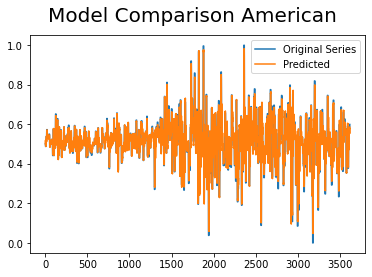

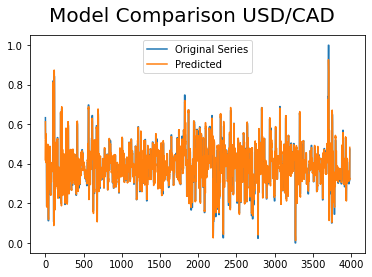

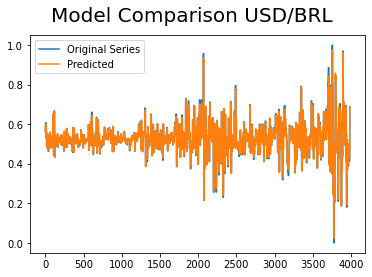

In [16]:
plot_2_series(real=american_y_train,
            model=clf_American.predict(american_X_train),
            title='Model Comparison American',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_CAD_y_train,
            model=clf_USD_CAD.predict(USD_CAD_X_train),
            title='Model Comparison USD/CAD',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_BRL_y_train,
            model=clf_USD_BRL.predict(USD_BRL_X_train),
            title='Model Comparison USD/BRL',
            xlabel='Years',
            ylabel='Value')

### Forecasting and Plotting

In [17]:
american_forecast = clf_American.predict(american_X_test)
USD_CAD_forecast = clf_USD_CAD.predict(USD_CAD_X_test)
USD_BRL_forecast = clf_USD_BRL.predict(USD_BRL_X_test)

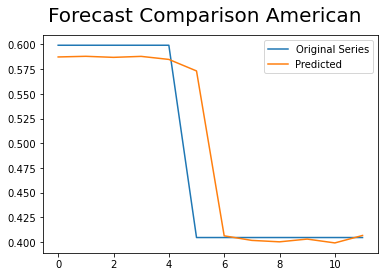

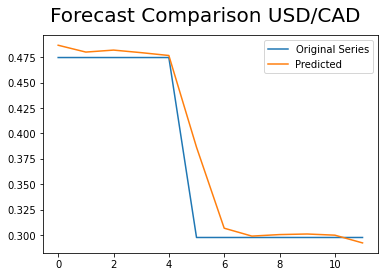

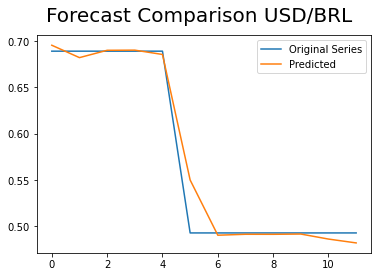

In [18]:
plot_2_series(real=american_y_test,
            model=american_forecast,
            title='Forecast Comparison American',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_CAD_y_test,
            model=USD_CAD_forecast,
            title='Forecast Comparison USD/CAD',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_BRL_y_test,
            model=USD_BRL_forecast,
            title='Forecast Comparison USD/BRL',
            xlabel='Years',
            ylabel='Value')

### Error Metrics

In [19]:
print("\nAmerican Forecast Errors")
print(errors(american_y_test,american_forecast))
print("\nUSD/CAD Forecast Errors")
print(errors(USD_CAD_y_test,USD_CAD_forecast))
print("\nUSD/BRL Forecast Errors")
print(errors(USD_BRL_y_test,USD_BRL_forecast))


American Forecast Errors
  Error     Value
0  MAPE  0.046887
1    ME  0.008097
2   MAE  0.020622
3   MPE  0.024080
4  RMSE  0.049341

USD/CAD Forecast Errors
  Error     Value
0  MAPE  0.037253
1    ME  0.011178
2   MAE  0.012069
3   MPE  0.034259
4  RMSE  0.026273

USD/BRL Forecast Errors
  Error     Value
0  MAPE  0.016017
1    ME  0.002591
2   MAE  0.008343
3   MPE  0.005356
4  RMSE  0.017176


### Creating the models (tensorflow.keras) for each Time Series with the best hypermaprameters (sklearn)

The only real reason we have searched the hyperparameter with sklearn but will create models with tensorflow.keras is the fact we want to learn how to use this library

In [302]:
#Run this cell if necessary
del model_american
del model_USD_CAD
del model_USD_BRL

In [303]:
model_american = create_model(hidden_neurons = [20], output_activation='linear', n_input = american_X_train.shape[1], n_output = 1, lr = 0.05)
model_USD_CAD = create_model(hidden_neurons = [20], output_activation='linear', n_input = USD_CAD_X_train.shape[1], n_output = 1, lr = 0.05)
model_USD_BRL = create_model(hidden_neurons = [20], output_activation='linear', n_input = USD_BRL_X_train.shape[1], n_output = 1, lr = 0.05)

Let's see the summary of each model

In [304]:
print("American Model")
print(model_american.summary())
print("USD/CAD Model")
print(model_USD_CAD.summary())
print("USD,BRL Model")
print(model_USD_BRL.summary())

American Model
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 20)                280       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 21        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________
None
USD/CAD Model
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 20)                280       
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 21        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


### Fit Models

In [305]:
model_american.fit(x=american_X_train,y=american_y_train,epochs=50)
model_USD_CAD.fit(x=USD_CAD_X_train,y=USD_CAD_y_train,epochs=50)
model_USD_BRL.fit(x=USD_BRL_X_train,y=USD_BRL_y_train,epochs=50)

Epoch 1/50
114/114 [==============================] - 0s 655us/step - loss: 0.1419 - mean_absolute_error: 0.1419 - mean_squared_error: 0.0738 - accuracy: 0.0028
Epoch 2/50
114/114 [==============================] - 0s 708us/step - loss: 0.0606 - mean_absolute_error: 0.0606 - mean_squared_error: 0.0073 - accuracy: 0.0028
Epoch 3/50
114/114 [==============================] - 0s 735us/step - loss: 0.0563 - mean_absolute_error: 0.0563 - mean_squared_error: 0.0066 - accuracy: 0.0028
Epoch 4/50
114/114 [==============================] - 0s 743us/step - loss: 0.0454 - mean_absolute_error: 0.0454 - mean_squared_error: 0.0053 - accuracy: 0.0028
Epoch 5/50
114/114 [==============================] - 0s 734us/step - loss: 0.0435 - mean_absolute_error: 0.0435 - mean_squared_error: 0.0053 - accuracy: 0.0028
Epoch 6/50
114/114 [==============================] - 0s 850us/step - loss: 0.0457 - mean_absolute_error: 0.0457 - mean_squared_error: 0.0056 - accuracy: 0.0025
Epoch 7/50
114/114 [==============

### Predicting the series via model

In [306]:
american_predicted = model_american.predict(american_X_train)
USD_CAD_predicted = model_american.predict(USD_CAD_X_train)
USD_BRL_predicted = model_american.predict(USD_BRL_X_train)

### Plotting original vs predicted series 

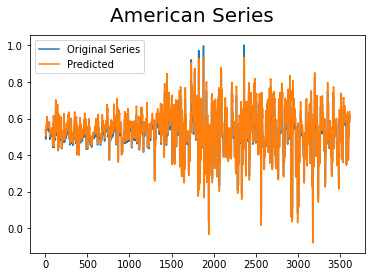

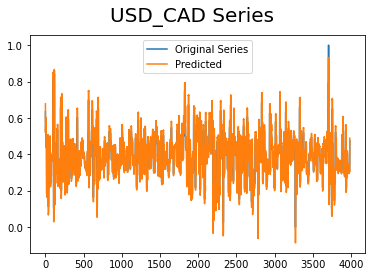

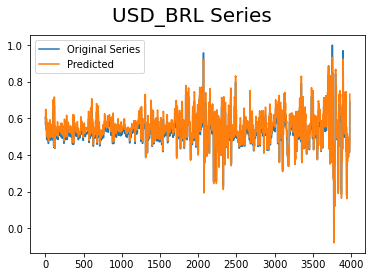

In [310]:
plot_2_series(american_y_train,american_predicted,title="American Series")
plot_2_series(USD_CAD_y_train,USD_CAD_predicted,title="USD_CAD Series")
plot_2_series(USD_BRL_y_train,USD_BRL_predicted,title="USD_BRL Series")

#### Prediction Errors

In [321]:
import warnings
warnings.filterwarnings('ignore')

print("\nAmerican Training Errors")
print(errors(american_y_train,american_predicted))
print("\nUSD/CAD Training Errors")
print(errors(USD_CAD_y_train,USD_CAD_predicted))
print("\nUSD/BRL Training Errors")
print(errors(USD_BRL_y_train,USD_BRL_predicted))


American Training Errors
  Error     Value
0  MAPE       inf
1    ME  0.022043
2   MAE  0.144201
3   MPE       NaN
4  RMSE  0.189023

USD/CAD Training Errors
  Error     Value
0  MAPE       inf
1    ME  0.005129
2   MAE  0.141101
3   MPE       NaN
4  RMSE  0.181482

USD/BRL Training Errors
  Error     Value
0  MAPE       inf
1    ME  0.024933
2   MAE  0.103176
3   MPE       NaN
4  RMSE  0.140169


### Forecasting

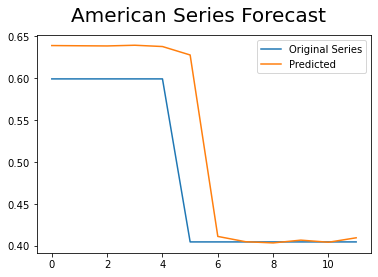

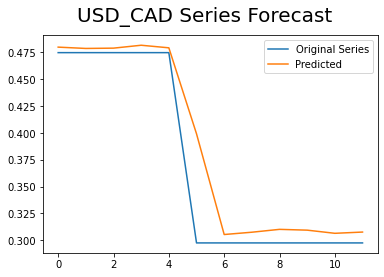

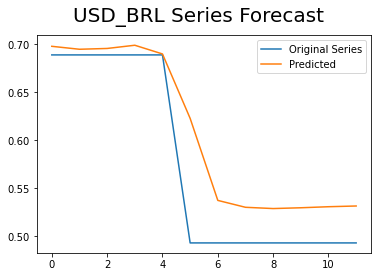

In [313]:
american_forecast = model_american.predict(american_X_test)
USD_CAD_forecast = model_USD_CAD.predict(USD_CAD_X_test)
USD_BRL_forecast = model_USD_BRL.predict(USD_BRL_X_test)


plot_2_series(american_y_test,american_forecast,title="American Series Forecast")
plot_2_series(USD_CAD_y_test,USD_CAD_forecast,title="USD_CAD Series Forecast")
plot_2_series(USD_BRL_y_test,USD_BRL_forecast,title="USD_BRL Series Forecast")


#### Forecast Errors

In [322]:
print("\nAmerican Forecast Errors")
print(errors(american_y_test,american_forecast))
print("\nUSD/CAD Forecast Errors")
print(errors(USD_CAD_y_test,USD_CAD_forecast))
print("\nUSD/BRL Forecast Errors")
print(errors(USD_BRL_y_test,USD_BRL_forecast))


American Forecast Errors
  Error     Value
0  MAPE  0.249200
1    ME  0.036058
2   MAE  0.116412
3   MPE  0.114976
4  RMSE  0.154111

USD/CAD Forecast Errors
  Error     Value
0  MAPE  0.255771
1    ME  0.015619
2   MAE  0.090382
3   MPE  0.098266
4  RMSE  0.120765

USD/BRL Forecast Errors
  Error     Value
0  MAPE  0.188194
1    ME  0.032744
2   MAE  0.103073
3   MPE  0.086109
4  RMSE  0.128792
